In [112]:
import sqlite3
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
import matplotlib
import operator
%matplotlib inline
import os
os.chdir('..')
from utilities.analysis import create_average_deck
os.chdir('notebooks/')

In [113]:
conn = sqlite3.connect('../netrunnerdb.db')
card_data = pd.read_sql('SELECT * FROM cards;', conn)
card_data.head()
noise_code = card_data.loc[(card_data['title'].str.startswith('Noise')), 'code'].values[0]
print(card_data.head())

   id                               title card_type   faction  \
0   1     The Shadow: Pulling the Strings  Identity   Neutral   
1   2           The Masque: Cyber General  Identity   Neutral   
2   3         Wyvern: Chemically Enhanced  Identity    Anarch   
3   4  Boris "Syfr" Kovac: Crafty Veteran  Identity  Criminal   
4   5  Jamie "Bzzz" Micken: Techno Savant  Identity    Shaper   

                                                text   code uniqueness  \
0  Draft format only.\r\nYou can use agendas from...  00005          0   
1                                 Draft format only.  00006          0   
2  If you have more Anarch cards installed than a...  00007          0   
3  If you have more Criminal cards installed than...  00008          0   
4  If you have more Shaper cards installed than a...  00009          0   

  cyclenumber faction_letter limited decksize number set_code    side  \
0           0              -       3       30      5    draft    Corp   
1           0     

In [114]:
decklist_data = pd.read_sql('SELECT * FROM decklist WHERE card_id = "%s";' % (noise_code,), conn)

In [115]:
decklist_data['deck_id'].value_counts()
decklist_data = decklist_data['deck_id']
decklist_data.drop_duplicates(inplace=True)

In [116]:
decklist_data.count()
decklist_data = pd.DataFrame(decklist_data)

In [117]:
deck_data = pd.read_sql('SELECT * FROM decks;', conn)
deck_data = deck_data.merge(decklist_data, how='right', left_on='deck_id', right_on='deck_id')
deck_data.head()

,id,deck_id,name,username,description,created_at
0,1,699,The Source of Noise v1.0,Diegofsv,This deck was based on Chakanantics by paddosa...,2013-12-01 23:18:29
1,3,698,The Most Boring Runner Deck to Play Against,shazzner,This is Noise solitaire deck that everyone was...,2013-12-01 16:30:32
2,33,738,Parasital Nightmare v4,Ratatosk,<p>Current Version of my deck built around rec...,2013-12-03 20:01:59
3,40,728,Noise Anarch 1.0 RAK: Suggestions please?,Rakshasa,I'm pretty certain I need to trim ten cards ou...,2013-12-03 11:05:56
4,46,736,Quiet Riot (Feedback),CodeMarvelous,<p>Install cheaply and cycle viruses in order ...,2013-12-03 14:58:58


In [118]:
deck_data['username'].value_counts().head(25)

CodeMarvelous     37
SlySquid          15
x3r0h0ur          12
djackman          10
Ulkrond            9
imrahil            9
bewnt              8
Oathwood           7
travisrchance      7
chrispedersen      7
daytodave          6
SgtFrenzy          6
Clockwork          6
Kroen              6
lizrrdbreath       6
Spoonfunk          6
king_mob           5
Alternity          5
Dydra              5
xanarax            5
neoreadinggrid     5
ShottyMonsta       5
arribous           5
slk                5
paulxthompson      5
Name: username, dtype: int64

In [119]:
deck_data['created_at'].describe()

count                    1249
unique                   1249
top       2015-01-28 20:38:23
freq                        1
Name: created_at, dtype: object

In [120]:
deck_data['created_at_dt'] = deck_data['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [121]:
deck_data['created_at_dt_date'] = deck_data['created_at_dt'].apply(lambda x: x.date())

In [122]:
deck_data['created_at_dt_date'].value_counts().head(25)

2015-07-28    9
2014-08-20    8
2014-05-28    7
2015-05-21    7
2015-08-17    7
2015-03-08    7
2014-11-02    7
2015-03-20    7
2014-05-15    7
2015-05-19    6
2015-02-08    6
2014-07-09    6
2014-08-25    6
2015-01-30    6
2015-01-10    6
2014-09-09    6
2015-10-28    6
2014-04-10    6
2014-10-14    6
2014-02-19    6
2015-09-01    5
2014-10-18    5
2015-03-02    5
2014-12-22    5
2015-06-14    5
Name: created_at_dt_date, dtype: int64

In [123]:
deck_data.count()

id                    1249
deck_id               1249
name                  1249
username              1249
description           1249
created_at            1249
created_at_dt         1249
created_at_dt_date    1249
dtype: int64

In [124]:
deck_data_graph = deck_data.copy()
deck_data_graph = deck_data_graph.set_index(deck_data_graph['created_at_dt'])
deck_data_graph['count'] = 1
deck_data_graph = deck_data_graph['count'].resample('M', how='count', closed='right')[1:-1].reset_index()
deck_data_graph.columns = ['date', 'value']
deck_data_graph['date'] = deck_data_graph['date'].apply(lambda x: x.strftime('%m-%Y'))
deck_data_graph.to_json('../../netrunner_website/data/noise-counts.json', orient='index')
deck_data_graph['value'].mean()

49.119999999999997

In [125]:
decklists = pd.read_sql('SELECT * FROM decklist;', conn)
decklists = decklists.merge(card_data, how='left', left_on='card_id', right_on='code')
decklists = decklists[['deck_id', 'title', 'quantity_x']]
cards_with_name = decklists.merge(decklist_data, how='right', left_on='deck_id', right_on='deck_id')
cards_with_name = cards_with_name.loc[(cards_with_name['title'] != 'Noise: Hacker Extraordinaire')]
cards_with_name.head()

,deck_id,title,quantity_x
0,29846,Darwin,2
1,29846,Sure Gamble,3
3,29846,Déjà Vu,3
4,29846,Wyldside,2
5,29846,Mimic,1


In [126]:
df = cards_with_name.copy()
df = df.groupby(['deck_id', 'title'])['quantity_x'].max().unstack()
df.fillna(0, inplace=True)
df.head()

title,Access to Globalsec,Account Siphon,Activist Support,Adjusted Chronotype,Aesop's Pawnshop,Akamatsu Mem Chip,Alias,All-nighter,Amped Up,Apocalypse,...,Wasteland,Wireless Net Pavilion,Woman in the Red Dress,Wyldside,Wyrm,Xanadu,Yog.0,ZU.13 Key Master,Zona Sul Shipping,e3 Feedback Implants
deck_id,,,,,,,,,,,,,,,,,,,,,
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10020,0,0,0,0,2,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
10041,0,0,0,0,2,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
10043,0,0,0,0,1,0,0,0,0,0,...,0,0,0,2,0,2,2,0,0,0
10060,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [127]:
df_normalized = df.copy()
df_normalized = df_normalized.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
df_normalized.head()

title,Access to Globalsec,Account Siphon,Activist Support,Adjusted Chronotype,Aesop's Pawnshop,Akamatsu Mem Chip,Alias,All-nighter,Amped Up,Apocalypse,...,Wasteland,Wireless Net Pavilion,Woman in the Red Dress,Wyldside,Wyrm,Xanadu,Yog.0,ZU.13 Key Master,Zona Sul Shipping,e3 Feedback Implants
deck_id,,,,,,,,,,,,,,,,,,,,,
1002,0,0,0,0,0.000000,0,0,0,0,0,...,0,0,0,0.000000,0,0.000000,0.000000,0,0,0
10020,0,0,0,0,0.666667,0,0,0,0,0,...,0,0,0,0.666667,0,0.000000,0.000000,0,0,0
10041,0,0,0,0,0.666667,0,0,0,0,0,...,0,0,0,0.666667,0,0.000000,0.000000,0,0,0
10043,0,0,0,0,0.333333,0,0,0,0,0,...,0,0,0,0.666667,0,0.666667,0.666667,0,0,0
10060,0,0,0,0,0.666667,0,0,0,0,0,...,0,0,0,0.000000,0,0.000000,0.333333,0,0,0


In [128]:
df_normalized['Aesop\'s Pawnshop'].value_counts()

0.000000    490
1.000000    331
0.666667    303
0.333333    125
Name: Aesop's Pawnshop, dtype: int64

In [129]:
model = TSNE(n_components=2)
transformed = pd.DataFrame(model.fit_transform(df_normalized), columns=['X', 'Y'])

(-30.0, 30.0, -30.0, 30.0)

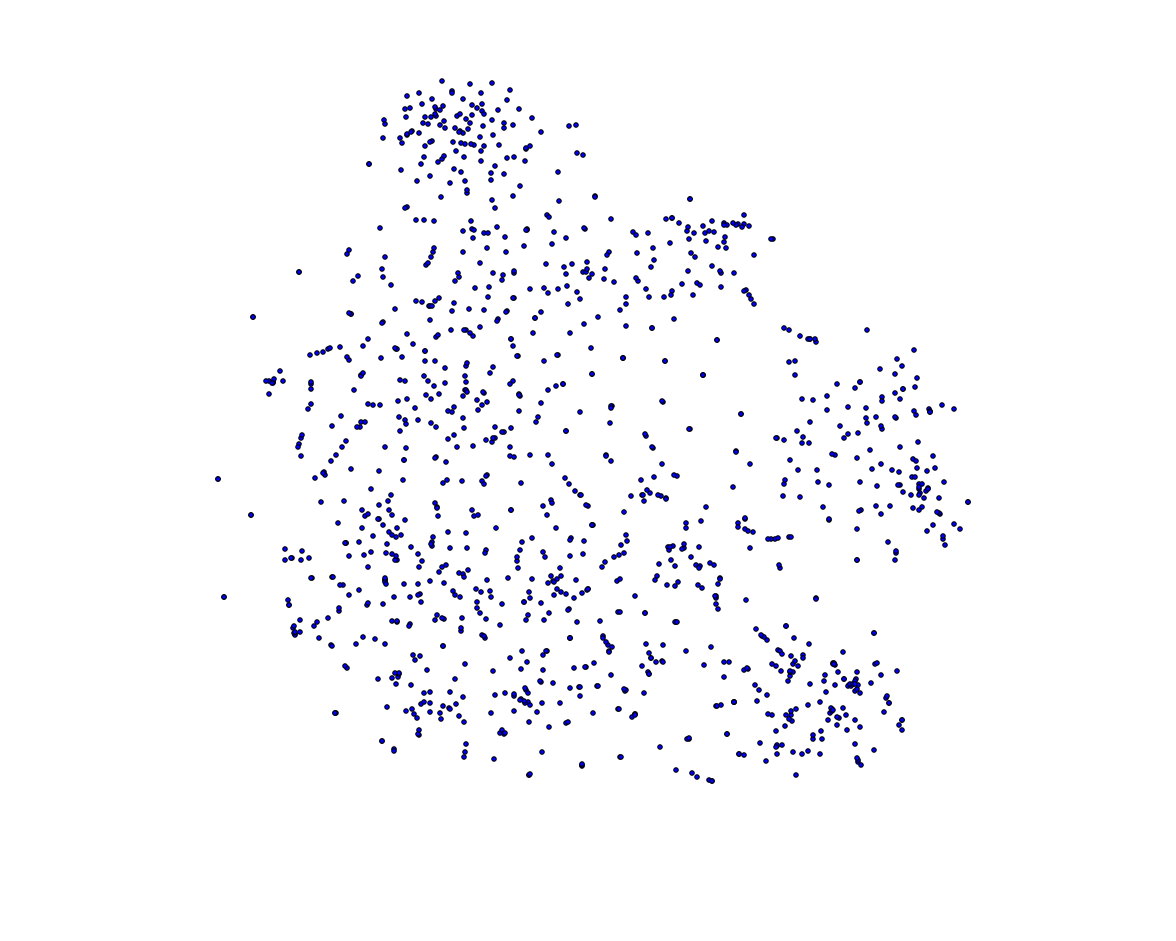

In [130]:
transformed.plot(kind='scatter', 
                 x='X', y='Y',
                figsize=(20,16))
matplotlib.pyplot.axis('off')

In [131]:
tfidftran = TfidfTransformer()
def_values = tfidftran.fit_transform(df_normalized)
print(def_values.toarray())

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [132]:
kmeans = KMeans(n_clusters=6,
               verbose=10)
kmeans.fit(def_values.toarray())

Initialization complete
Iteration  0, inertia 1401.714
Iteration  1, inertia 833.582
Iteration  2, inertia 822.028
Iteration  3, inertia 816.323
Iteration  4, inertia 812.584
Iteration  5, inertia 809.638
Iteration  6, inertia 807.940
Iteration  7, inertia 807.106
Iteration  8, inertia 806.404
Iteration  9, inertia 805.293
Iteration 10, inertia 804.125
Iteration 11, inertia 803.407
Iteration 12, inertia 803.046
Iteration 13, inertia 802.578
Iteration 14, inertia 802.097
Iteration 15, inertia 801.732
Iteration 16, inertia 801.061
Iteration 17, inertia 800.545
Iteration 18, inertia 800.376
Iteration 19, inertia 800.316
Iteration 20, inertia 800.294
Iteration 21, inertia 800.285
Converged at iteration 21
Initialization complete
Iteration  0, inertia 1376.953
Iteration  1, inertia 848.647
Iteration  2, inertia 821.834
Iteration  3, inertia 813.291
Iteration  4, inertia 811.432
Iteration  5, inertia 810.198
Iteration  6, inertia 808.032
Iteration  7, inertia 806.186
Iteration  8, inertia 80

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=10)

In [133]:
kmeans.labels_

array([2, 2, 2, ..., 3, 1, 1], dtype=int32)

In [134]:
transformed = transformed.join(pd.DataFrame(kmeans.labels_, columns=['grouping']))

In [135]:
transformed
transformed['X'].min()
transformed['Y'].min()
transformed['X'] = transformed['X'] + 25
transformed['Y'] = transformed['Y'] + 25


In [136]:
print(transformed['X'].min(), transformed['Y'].min())

4.18557722111 3.29816101813


(0.0, 50.0, 0.0, 60.0)

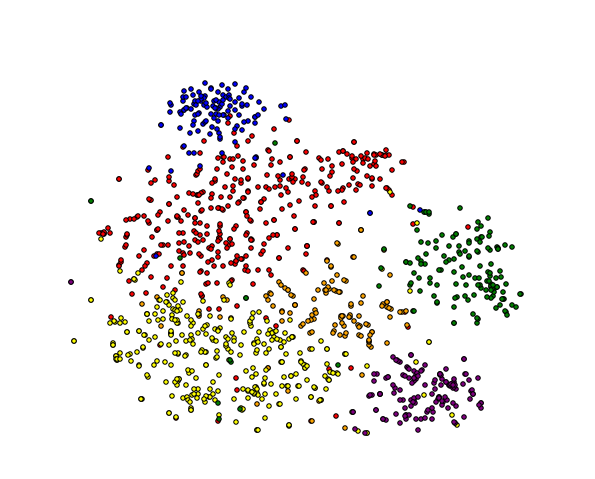

In [137]:
colors = ['red', 'orange', 'yellow',
         'green', 'blue', 'purple',
         'black']

zipped = zip(transformed['grouping'].unique(), colors)

matplotlib.pyplot.figure(figsize=(10,8))

for groups, colors in zipped:
    matplotlib.pylab.scatter(transformed.loc[(transformed['grouping'] == groups), 'X'], 
                             transformed.loc[(transformed['grouping'] == groups), 'Y'],
                            c=colors, 
                            )
matplotlib.pyplot.axis('off')


In [138]:
df_clustering = df.copy()
df_clustering['index'] = [x for x in range(0, len(df_clustering))]
df_clustering = df_clustering.set_index('index')
df_clustering = df_clustering.join(pd.DataFrame(kmeans.labels_, columns=['grouping']))

transformed
df_deckids = df.copy()
df_deckids['index'] = [x for x in range(0, len(df_clustering))]
df_deckids = pd.DataFrame(df_deckids['index'])
df_deckids = df_deckids.merge(transformed, how='inner', left_on='index', right_index=True)
df_deckids

decks_to_send = deck_data.copy()
decks_to_send = decks_to_send.merge(df_deckids, how='inner', left_on='deck_id', right_index=True)
decks_to_send['date'] = decks_to_send['created_at_dt_date'].apply(lambda x: x.strftime('%m-%d-%Y'))
decks_to_send = decks_to_send[['X', 'Y', 'deck_id', 'grouping', 'name', 'date']]
decks_to_send
# decks_to_send.to_json('../../netrunner_website/data/noise-deck.json', orient='index')

In [147]:
decks_to_send['date_dt'] = decks_to_send['date'].apply(lambda x: datetime.strptime(x, '%m-%d-%Y'))


,X,Y,deck_id,grouping,name,date,date_dt
0,13.014616,34.083749,699,2,The Source of Noise v1.0,12-01-2013,2013-12-01
1,22.151292,24.617278,698,2,The Most Boring Runner Deck to Play Against,12-01-2013,2013-12-01
2,11.877757,27.441187,738,2,Parasital Nightmare v4,12-03-2013,2013-12-03
3,14.344987,49.341953,728,0,Noise Anarch 1.0 RAK: Suggestions please?,12-03-2013,2013-12-03
4,16.083452,29.307922,736,2,Quiet Riot (Feedback),12-03-2013,2013-12-03


In [171]:
for group in decks_to_send['grouping'].unique():
    print(group)
    print(decks_to_send.loc[(decks_to_send['grouping'] == group)].count())
    print(decks_to_send.loc[(decks_to_send['grouping'] == group), ['date_dt','X']].set_index('date_dt').resample('M', how='count').sort_values(by='X', ascending=False).head())

2
X           385
Y           385
deck_id     385
grouping    385
name        385
date        385
date_dt     385
dtype: int64
             X
date_dt       
2014-06-30  44
2014-03-31  43
2014-02-28  41
2014-07-31  41
2014-04-30  35
0
X           121
Y           121
deck_id     121
grouping    121
name        121
date        121
date_dt     121
dtype: int64
             X
date_dt       
2015-06-30  12
2015-08-31  10
2015-11-30   9
2015-05-31   8
2016-01-31   8
1
X           124
Y           124
deck_id     124
grouping    124
name        124
date        124
date_dt     124
dtype: int64
             X
date_dt       
2014-12-31  18
2014-10-31  14
2014-08-31  13
2014-09-30   8
2014-11-30   8
3
X           330
Y           330
deck_id     330
grouping    330
name        330
date        330
date_dt     330
dtype: int64
             X
date_dt       
2014-08-31  37
2015-05-31  36
2015-01-31  33
2014-11-30  32
2015-04-30  27
5
X           147
Y           147
deck_id     147
grouping    147
name  

In [172]:
groupone = df_clustering.copy()
groupone = groupone.loc[(groupone['grouping'] == 1)]
cards = list(groupone.columns)
cards = [card for card in cards if card != 'grouping']
average_card_usage = {}
for card in cards:
    average = groupone[card].describe()['mean']
    if average > 0.0:
        average_card_usage[card] = average
        
average_card_usage

{'Account Siphon': 0.016129032258064516,
 'Activist Support': 0.064516129032258063,
 'Adjusted Chronotype': 0.31451612903225806,
 "Aesop's Pawnshop": 1.6370967741935485,
 'Amped Up': 0.12903225806451613,
 'Apocalypse': 0.016129032258064516,
 'Armitage Codebusting': 0.096774193548387094,
 'Autoscripter': 0.18548387096774194,
 'Beach Party': 0.056451612903225805,
 'Blackmail': 0.13709677419354838,
 'Box-E': 0.064516129032258063,
 'Cache': 2.5806451612903225,
 'Cerberus "Cuj.0" H3': 0.0080645161290322578,
 'Chakana': 0.040322580645161289,
 'Chop Bot 3000': 0.24193548387096775,
 'Clone Chip': 0.29838709677419356,
 'Clot': 0.31451612903225806,
 'Comet': 0.032258064516129031,
 'Corroder': 0.2661290322580645,
 'Crypsis': 0.95161290322580649,
 'Cyber Threat': 0.056451612903225805,
 'Cyber-Cypher': 0.032258064516129031,
 'Cyberfeeder': 1.3870967741935485,
 'Cybsoft MacroDrive': 0.016129032258064516,
 'D4v1d': 0.2661290322580645,
 'Daily Casts': 0.47580645161290325,
 'Darwin': 0.7983870967741935

In [173]:
sorted_dict = sorted(average_card_usage.items(), key=operator.itemgetter(1), reverse=True)
sorted_dict

[('Datasucker', 2.8225806451612905),
 ('Cache', 2.5806451612903225),
 ('Déjà Vu', 2.379032258064516),
 ('Lamprey', 2.2903225806451615),
 ('Imp', 2.0725806451612905),
 ('Mass Install', 1.7983870967741935),
 ('Parasite', 1.7096774193548387),
 ('Scheherazade', 1.6693548387096775),
 ("Aesop's Pawnshop", 1.6370967741935485),
 ('Wyldside', 1.5403225806451613),
 ('Gorman Drip v1', 1.4838709677419355),
 ('Cyberfeeder', 1.3870967741935485),
 ('Sure Gamble', 1.3225806451612903),
 ('Grimoire', 1.185483870967742),
 ('Ixodidae', 1.1370967741935485),
 ('Crypsis', 0.95161290322580649),
 ('Medium', 0.88709677419354838),
 ('Darwin', 0.79838709677419351),
 ('Djinn', 0.75806451612903225),
 ('Hemorrhage', 0.66935483870967738),
 ('Same Old Thing', 0.64516129032258063),
 ("I've Had Worse", 0.63709677419354838),
 ('Nerve Agent', 0.63709677419354838),
 ("Duggar's", 0.59677419354838712),
 ('Hades Shard', 0.56451612903225812),
 ('Daily Casts', 0.47580645161290325),
 ('Sahasrara', 0.47580645161290325),
 ('Levy A

In [174]:
groupone['Sure Gamble'].describe()

count    124.000000
mean       1.322581
std        1.479114
min        0.000000
25%        0.000000
50%        0.000000
75%        3.000000
max        3.000000
Name: Sure Gamble, dtype: float64

In [175]:
average_deck = []
card_counter = 0

for card in sorted_dict:
    card_count = round(card[1])
    card_counter += card_count
    if card_counter < 45:
        average_deck.append((card[0], card_count, card[1]))
    elif card_counter == 45:
        average_deck.append((card[0], card_count, card[1]))
        break
    else:
        amount_over = card_counter - 45
        card_count = card_count - amount_over
        average_deck.append((card[0], card_count, card[1]))
        pass

average_deck    

[('Datasucker', 3.0, 2.8225806451612905),
 ('Cache', 3.0, 2.5806451612903225),
 ('Déjà Vu', 2.0, 2.379032258064516),
 ('Lamprey', 2.0, 2.2903225806451615),
 ('Imp', 2.0, 2.0725806451612905),
 ('Mass Install', 2.0, 1.7983870967741935),
 ('Parasite', 2.0, 1.7096774193548387),
 ('Scheherazade', 2.0, 1.6693548387096775),
 ("Aesop's Pawnshop", 2.0, 1.6370967741935485),
 ('Wyldside', 2.0, 1.5403225806451613),
 ('Gorman Drip v1', 1.0, 1.4838709677419355),
 ('Cyberfeeder', 1.0, 1.3870967741935485),
 ('Sure Gamble', 1.0, 1.3225806451612903),
 ('Grimoire', 1.0, 1.185483870967742),
 ('Ixodidae', 1.0, 1.1370967741935485),
 ('Crypsis', 1.0, 0.95161290322580649),
 ('Medium', 1.0, 0.88709677419354838),
 ('Darwin', 1.0, 0.79838709677419351),
 ('Djinn', 1.0, 0.75806451612903225),
 ('Hemorrhage', 1.0, 0.66935483870967738),
 ('Same Old Thing', 1.0, 0.64516129032258063),
 ("I've Had Worse", 1.0, 0.63709677419354838),
 ('Nerve Agent', 1.0, 0.63709677419354838),
 ("Duggar's", 1.0, 0.59677419354838712),
 ('H

In [176]:
list_decks = create_average_deck(df_clustering, 45, clustering_column='grouping')

In [177]:
counter = 0
for deck in list_decks:
    counter +=1
    print('Clustered deck %s (Total decks in cluster %s)' % (counter, 
                                                            df_clustering.loc[df_clustering['grouping'] == counter-1].count()[0]))
    for cards in deck:
        print(cards[0], ' --- ', cards[1], '(%s)' % cards[2])
    print('\n')

Clustered deck 1 (Total decks in cluster 121)
Parasite  ---  3 (2.76883116883)
Sure Gamble  ---  3 (2.49090909091)
Datasucker  ---  3 (2.43636363636)
Déjà Vu  ---  3 (2.16623376623)
Djinn  ---  2 (1.76883116883)
Grimoire  ---  2 (1.74805194805)
Imp  ---  2 (1.74025974026)
Medium  ---  2 (1.33766233766)
Cyberfeeder  ---  2 (1.17662337662)
Crypsis  ---  2 (1.1012987013)
Daily Casts  ---  2 (1.08311688312)
Armitage Codebusting  ---  2 (1.08051948052)
Plascrete Carapace  ---  2 (1.05194805195)
Liberated Account  ---  1 (0.958441558442)
Corroder  ---  1 (0.922077922078)
Surge  ---  1 (0.906493506494)
Kati Jones  ---  1 (0.864935064935)
Dirty Laundry  ---  1 (0.812987012987)
Knight  ---  1 (0.802597402597)
Nerve Agent  ---  1 (0.792207792208)
Clone Chip  ---  1 (0.792207792208)
Wyldside  ---  1 (0.781818181818)
Mimic  ---  1 (0.72987012987)
Same Old Thing  ---  1 (0.724675324675)
Gorman Drip v1  ---  1 (0.722077922078)
Darwin  ---  1 (0.654545454545)
Account Siphon  ---  1 (0.607792207792)
D

## Ok, now for decks in the last few months

In [94]:
deck_data[['created_at_dt_date', 'username']].head()

,created_at_dt_date,username
0,2013-12-01,Diegofsv
1,2013-12-01,shazzner
2,2013-12-03,Ratatosk
3,2013-12-03,Rakshasa
4,2013-12-03,CodeMarvelous


In [95]:
deck_data['within_six_months'] = deck_data['created_at_dt'].apply(lambda x: 1 if (datetime.today() - x).days <= 180
                                                                 else 0)
six_months_deck = deck_data.copy()
six_months_deck = six_months_deck.loc[(six_months_deck['within_six_months'] == 1)]
six_months_deck.head()

,id,deck_id,name,username,description,created_at,created_at_dt,created_at_dt_date,within_six_months
1050,21508,25162,Noise 1st Place at Argentina Open 2015,Tubulario,<p>Argentina Open 2015 1st place</p>\n\n<p>19 ...,2015-08-18 20:20:39,2015-08-18 20:20:39,2015-08-18,1
1052,21591,25201,Make some Noise,deznil,<p>First Noise Decklist</p>\n,2015-08-19 12:05:19,2015-08-19 12:05:19,2015-08-19,1
1053,21600,25244,Noisy Cache 3.5,johncraven,<p>Film critic rocks.</p>\n,2015-08-20 05:11:48,2015-08-20 05:11:48,2015-08-20,1
1054,21636,25240,Party DNA,Sneakdoorbeta,\n,2015-08-20 05:08:34,2015-08-20 05:08:34,2015-08-20,1
1055,21646,25237,Core Tag Me,alilja,\n,2015-08-20 03:38:00,2015-08-20 03:38:00,2015-08-20,1


In [96]:
decklists = pd.read_sql('SELECT * FROM decklist;', conn)
decklists = decklists.merge(card_data, how='left', left_on='card_id', right_on='code')
decklists = decklists[['deck_id', 'title', 'quantity_x']]
cards_with_name = decklists.merge(six_months_deck, how='right', left_on='deck_id', right_on='deck_id')
cards_with_name = cards_with_name.loc[(cards_with_name['title'] != 'Noise: Hacker Extraordinaire')]
cards_with_name = cards_with_name[['deck_id', 'title', 'quantity_x']]
cards_with_name.head()

,deck_id,title,quantity_x
0,29846,Darwin,2
1,29846,Sure Gamble,3
3,29846,Déjà Vu,3
4,29846,Wyldside,2
5,29846,Mimic,1


In [97]:
df = cards_with_name.copy()
df = df.groupby(['deck_id', 'title'])['quantity_x'].max().unstack()
df.fillna(0, inplace=True)
df_normalized = df.copy()
df_normalized = df_normalized.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
df_normalized.head()
df.count()

title
Access to Globalsec      198
Account Siphon           198
Activist Support         198
Adjusted Chronotype      198
Aesop's Pawnshop         198
Akamatsu Mem Chip        198
Amped Up                 198
Apocalypse               198
Archives Interface       198
Armitage Codebusting     198
Atman                    198
Autoscripter             198
Bank Job                 198
Beach Party              198
Blackmail                198
Cache                    198
Career Fair              198
Cerberus "Cuj.0" H3      198
Chakana                  198
Chop Bot 3000            198
Clone Chip               198
Clot                     198
Comet                    198
Compromised Employee     198
Corroder                 198
Crash Space              198
Crypsis                  198
Cyber Threat             198
Cyberfeeder              198
D4v1d                    198
                        ... 
Street Peddler           198
Sure Gamble              198
Surge                    198
Symmetri

(-400.0, 400.0, -400.0, 500.0)

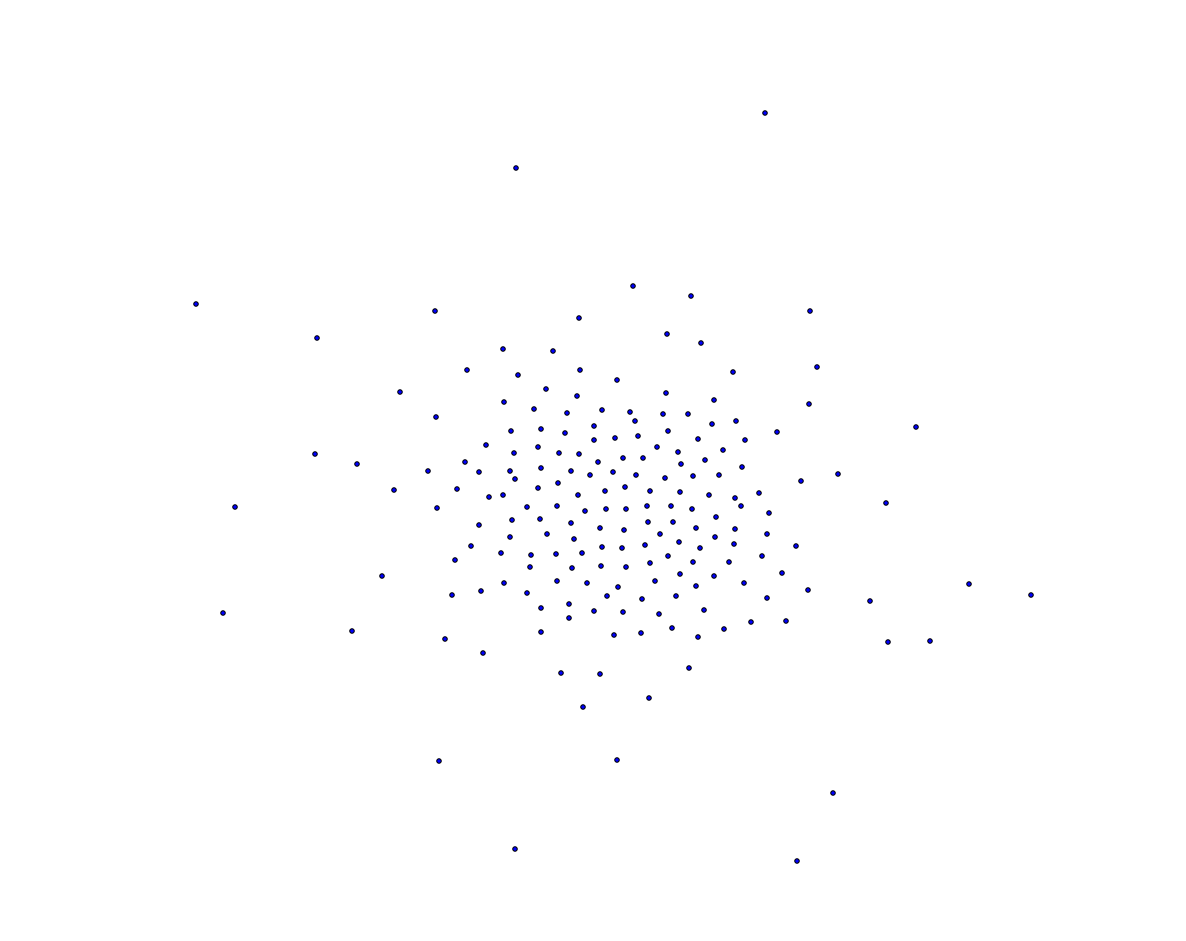

In [98]:
model = TSNE(n_components=2)
transformed_six_month = pd.DataFrame(model.fit_transform(df_normalized), columns=['X', 'Y'])
transformed_six_month.plot(kind='scatter', 
                 x='X', y='Y',
                figsize=(20,16))
matplotlib.pyplot.axis('off')

(0.0, 60.0, -10.0, 50.0)

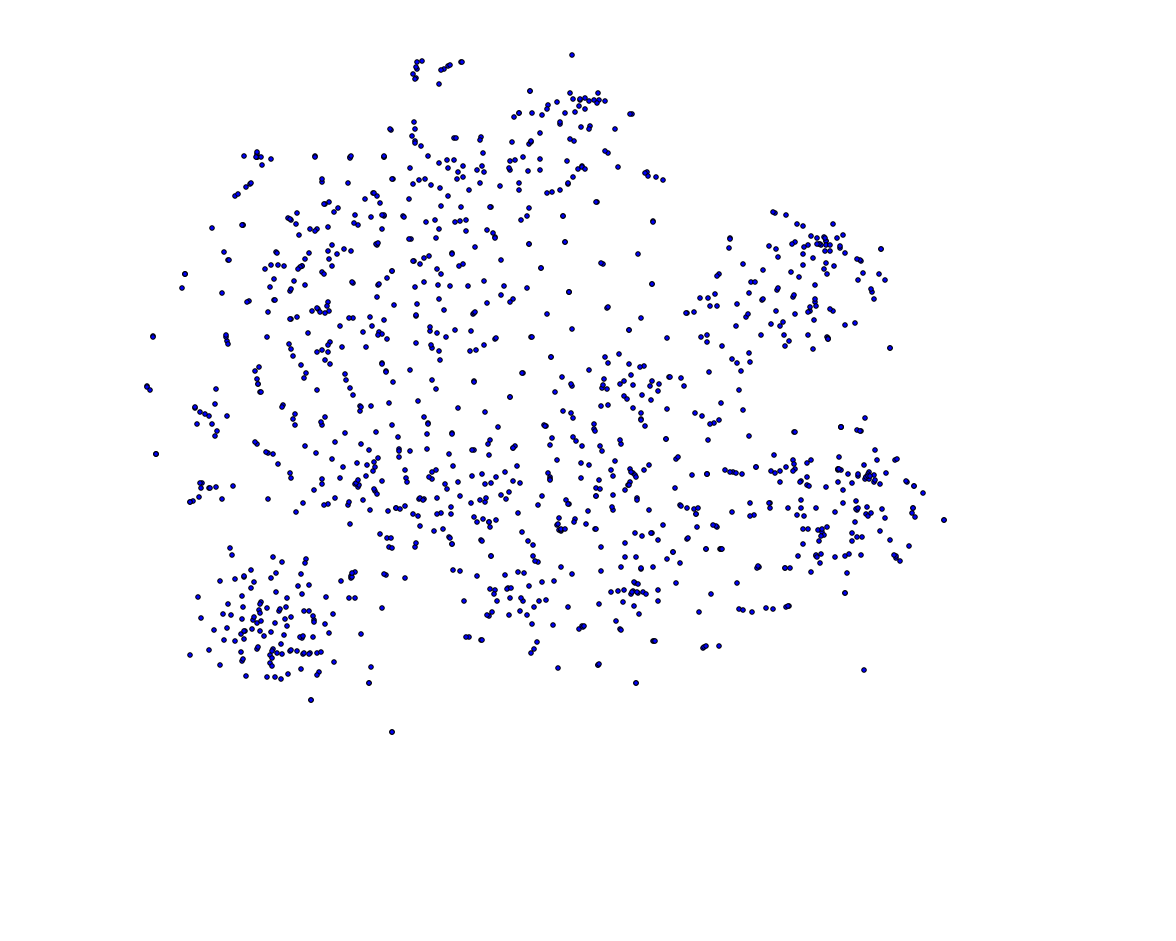

In [99]:
transformed.plot(kind='scatter', 
                 x='X', y='Y',
                figsize=(20,16))
matplotlib.pyplot.axis('off')

In [100]:
transformed_six_month.count()

X    198
Y    198
dtype: int64

In [101]:
tfidftran = TfidfTransformer()
def_values = tfidftran.fit_transform(df_normalized)
print(def_values.toarray())

[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.23774028  0.          0.        ]
 [ 0.          0.26690598  0.         ...,  0.16990162  0.          0.        ]
 ..., 
 [ 0.          0.3843377   0.         ...,  0.16310262  0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.18883809  0.          0.        ]]


In [102]:
df_clustering = df.copy()
df_deckids = df.copy()
df_deckids['index'] = [x for x in range(0, len(df_clustering))]
df_deckids = pd.DataFrame(df_deckids['index'])
df_deckids = df_deckids.merge(transformed_six_month, how='inner', left_on='index', right_index=True)
df_deckids

decks_to_send = deck_data.copy()
decks_to_send = decks_to_send.merge(df_deckids, how='inner', left_on='deck_id', right_index=True)

decks_to_send = decks_to_send[['X', 'Y', 'deck_id', 'name', 'created_at_dt_date']]
decks_to_send
# decks_to_send.to_json('../../netrunner_website/data/noise-deck.json', orient='index')

cards = list(df_clustering.columns)
cards = [card for card in cards if card != 'grouping']
average_card_usage = {}
for card in cards:
    average = df_clustering[card].describe()['mean']
    if average > 0.0:
        average_card_usage[card] = average
        
average_card_usage

sorted_dict = sorted(average_card_usage.items(), key=operator.itemgetter(1), reverse=True)
sorted_dict

[('Parasite', 2.6212121212121211),
 ('Déjà Vu', 2.5303030303030303),
 ('Datasucker', 2.5),
 ('Wyldside', 2.0050505050505052),
 ('Cache', 1.9898989898989898),
 ('Imp', 1.9343434343434343),
 ("Aesop's Pawnshop", 1.696969696969697),
 ('Grimoire', 1.6666666666666667),
 ('Medium', 1.5606060606060606),
 ('Sure Gamble', 1.4444444444444444),
 ('Street Peddler', 1.2121212121212122),
 ('Cyberfeeder', 1.1666666666666667),
 ('Adjusted Chronotype', 1.1515151515151516),
 ("I've Had Worse", 1.1363636363636365),
 ('Clone Chip', 1.1111111111111112),
 ('Faust', 1.0909090909090908),
 ('Daily Casts', 0.98989898989898994),
 ('Mimic', 0.97979797979797978),
 ('Corroder', 0.94444444444444442),
 ('D4v1d', 0.90404040404040409),
 ('Lamprey', 0.90404040404040409),
 ('Djinn', 0.86868686868686873),
 ('Armitage Codebusting', 0.80808080808080807),
 ('Clot', 0.71212121212121215),
 ('Yog.0', 0.53030303030303028),
 ('Crypsis', 0.44444444444444442),
 ('Stimhack', 0.38383838383838381),
 ('Gravedigger', 0.30303030303030304

In [103]:
average_deck = []
card_counter = 0

for card in sorted_dict:
    card_count = round(card[1])
    card_counter += card_count
    if card_counter < 45:
        average_deck.append((card[0], card_count, card[1]))
    elif card_counter == 45:
        average_deck.append((card[0], card_count, card[1]))
        break
    else:
        amount_over = card_counter - 45
        card_count = card_count - amount_over
        average_deck.append((card[0], card_count, card[1]))
        pass

average_deck

[('Parasite', 3.0, 2.6212121212121211),
 ('Déjà Vu', 3.0, 2.5303030303030303),
 ('Datasucker', 2.0, 2.5),
 ('Wyldside', 2.0, 2.0050505050505052),
 ('Cache', 2.0, 1.9898989898989898),
 ('Imp', 2.0, 1.9343434343434343),
 ("Aesop's Pawnshop", 2.0, 1.696969696969697),
 ('Grimoire', 2.0, 1.6666666666666667),
 ('Medium', 2.0, 1.5606060606060606),
 ('Sure Gamble', 1.0, 1.4444444444444444),
 ('Street Peddler', 1.0, 1.2121212121212122),
 ('Cyberfeeder', 1.0, 1.1666666666666667),
 ('Adjusted Chronotype', 1.0, 1.1515151515151516),
 ("I've Had Worse", 1.0, 1.1363636363636365),
 ('Clone Chip', 1.0, 1.1111111111111112),
 ('Faust', 1.0, 1.0909090909090908),
 ('Daily Casts', 1.0, 0.98989898989898994),
 ('Mimic', 1.0, 0.97979797979797978),
 ('Corroder', 1.0, 0.94444444444444442),
 ('D4v1d', 1.0, 0.90404040404040409),
 ('Lamprey', 1.0, 0.90404040404040409),
 ('Djinn', 1.0, 0.86868686868686873),
 ('Armitage Codebusting', 1.0, 0.80808080808080807),
 ('Clot', 1.0, 0.71212121212121215),
 ('Yog.0', 1.0, 0.53

### Set up MWL Shenanigans

In [104]:
mwl_runner_cards = {'Cerberus "Lady" H1': {'faction': 'shaper', 'inf': 3},
                   'Clone Chip': {'faction': 'shaper', 'inf': 2},
                   'Desperado': {'faction': 'criminal', 'inf': 3},
                   'Parasite': {'faction': 'anarch', 'inf': 2},
                    'Prepaid VoicePAD': {'faction': 'neutral', 'inf': 0},
                    'Yog.0': {'faction': 'anarch', 'inf': 1}
                   }

def test_mwl_runner_cards(faction):
    return_dict = {}
    for key, value in mwl_runner_cards.items():
        if value['faction'] == faction:
            return_dict[key] = 1
        else:
            return_dict[key] = (value['inf'] + 1) # really naive implementation
    return return_dict
            
print(test_mwl_runner_cards('anarch'))

{'Clone Chip': 3, 'Cerberus "Lady" H1': 4, 'Parasite': 1, 'Desperado': 4, 'Prepaid VoicePAD': 1, 'Yog.0': 1}


In [105]:
# Testing out
import math

mwl_tracker = 0
mwl_cards = test_mwl_runner_cards('anarch')
average_deck = []
card_counter = 0
for card in sorted_dict:
    card_count = math.ceil(card[1])
    card_counter += card_count
    if card[0] in mwl_cards.keys():
        mwl_tracker += card_count * mwl_cards[card[0]]
    print(card_counter, card[0], mwl_tracker)
    if card_counter < 45:
        average_deck.append((card[0], card_count, card[1]))
    elif card_counter == 45:
        average_deck.append((card[0], card_count, card[1]))
        break
    else:
        amount_over = card_counter - 45
        card_count = card_count - amount_over
        average_deck.append((card[0], card_count, card[1]))
        break

print(mwl_tracker)

3 Parasite 3
6 Déjà Vu 3
9 Datasucker 3
12 Wyldside 3
14 Cache 3
16 Imp 3
18 Aesop's Pawnshop 3
20 Grimoire 3
22 Medium 3
24 Sure Gamble 3
26 Street Peddler 3
28 Cyberfeeder 3
30 Adjusted Chronotype 3
32 I've Had Worse 3
34 Clone Chip 9
36 Faust 9
37 Daily Casts 9
38 Mimic 9
39 Corroder 9
40 D4v1d 9
41 Lamprey 9
42 Djinn 9
43 Armitage Codebusting 9
44 Clot 9
45 Yog.0 10
10


In [106]:
average_deck

[('Parasite', 3, 2.6212121212121211),
 ('Déjà Vu', 3, 2.5303030303030303),
 ('Datasucker', 3, 2.5),
 ('Wyldside', 3, 2.0050505050505052),
 ('Cache', 2, 1.9898989898989898),
 ('Imp', 2, 1.9343434343434343),
 ("Aesop's Pawnshop", 2, 1.696969696969697),
 ('Grimoire', 2, 1.6666666666666667),
 ('Medium', 2, 1.5606060606060606),
 ('Sure Gamble', 2, 1.4444444444444444),
 ('Street Peddler', 2, 1.2121212121212122),
 ('Cyberfeeder', 2, 1.1666666666666667),
 ('Adjusted Chronotype', 2, 1.1515151515151516),
 ("I've Had Worse", 2, 1.1363636363636365),
 ('Clone Chip', 2, 1.1111111111111112),
 ('Faust', 2, 1.0909090909090908),
 ('Daily Casts', 1, 0.98989898989898994),
 ('Mimic', 1, 0.97979797979797978),
 ('Corroder', 1, 0.94444444444444442),
 ('D4v1d', 1, 0.90404040404040409),
 ('Lamprey', 1, 0.90404040404040409),
 ('Djinn', 1, 0.86868686868686873),
 ('Armitage Codebusting', 1, 0.80808080808080807),
 ('Clot', 1, 0.71212121212121215),
 ('Yog.0', 1, 0.53030303030303028)]

In [107]:
for card in average_deck:
    print(card[0], card[1])

Parasite 3
Déjà Vu 3
Datasucker 3
Wyldside 3
Cache 2
Imp 2
Aesop's Pawnshop 2
Grimoire 2
Medium 2
Sure Gamble 2
Street Peddler 2
Cyberfeeder 2
Adjusted Chronotype 2
I've Had Worse 2
Clone Chip 2
Faust 2
Daily Casts 1
Mimic 1
Corroder 1
D4v1d 1
Lamprey 1
Djinn 1
Armitage Codebusting 1
Clot 1
Yog.0 1
